# Symbol prediction

Symbol prediction notebook

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow.keras.preprocessing.image import smart_resize

from resolve_symbols import resolve_symbols_on_img



Load in class labels from class_names.txt 

In [13]:
with open('../class_names.txt', 'r') as f:
    lines = f.readlines()
class_labels = [label.split(' ')[-1][:-1] for label in lines]

In [14]:
efficientnet_model = tf.keras.models.load_model('../CNN_model/efficientnet_model.h5')

In [15]:
full_eq_imgs = glob.glob('../full_eq_imgs/*png')

In [81]:
img_idx = 65

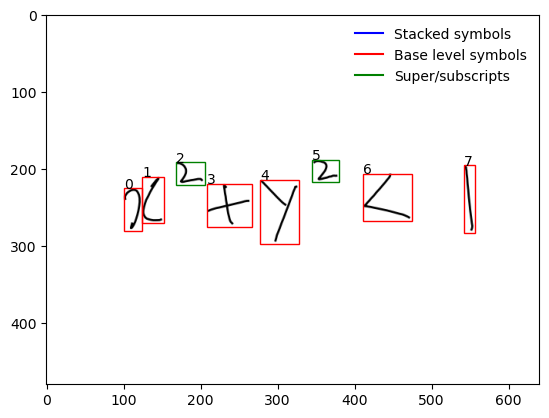

In [82]:
symbs, levels, stack, script_levels, ax = resolve_symbols_on_img(full_eq_imgs[img_idx])

In [83]:
pred_list = []
pred_symbol_list, pred_idx_list = [], []
for i, symbol in enumerate(symbs):
    rgb_im = np.zeros((symbol.shape[0], symbol.shape[1], 3))
    for i in range(3):
        rgb_im[:,:,i] = symbol.astype('uint8')
    resize_img = smart_resize(rgb_im, (100,100))
    resize_img = np.expand_dims(resize_img, axis=0)
    prediction = efficientnet_model.predict(resize_img)
    
    pred_dic = {k:v for v,k in sorted(zip(prediction[0], class_labels))[-4:]}
    y_classes = prediction.argmax(axis=-1)
    pred_idx_list.append(y_classes)
    pred_symbol_list.append(class_labels[y_classes[0]])
    pred_list.append(pred_dic)

1/1 [==============================] - 0s 26ms/step


In [84]:
pred_list[0]

{'label_]': 0.018694106,
 'label_,': 0.028303977,
 'label_1': 0.07568161,
 'label_7': 0.87169665}

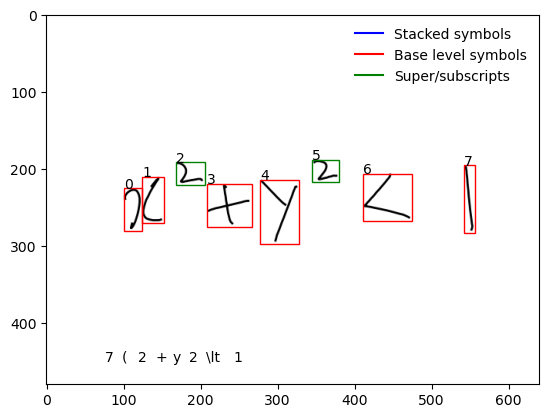

In [85]:
symbs, levels, stack, script_levels, ax = resolve_symbols_on_img(full_eq_imgs[img_idx])
add_y = 0
for i, symbol in enumerate(pred_symbol_list):
    ax.text(75+add_y, 450, symbol[6:])
    add_y += 15 + (7*len(symbol[6:]))

In [74]:
pred_symbol_list

['label_-',
 'label_n',
 'label_capital_B',
 'label_+',
 'label_capital_S',
 'label_-',
 'label_n',
 'label_capital_C',
 'label_capital_S',
 'label_-',
 'label_1',
 'label_1',
 'label_c',
 'label_0',
 'label_capital_S',
 'label_capital_B',
 'label_+',
 'label_c',
 'label_\\sigma',
 'label_capital_S',
 'label_capital_C']

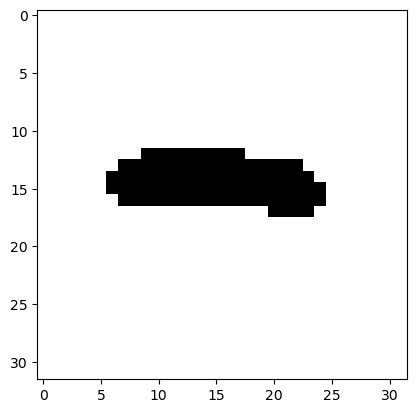

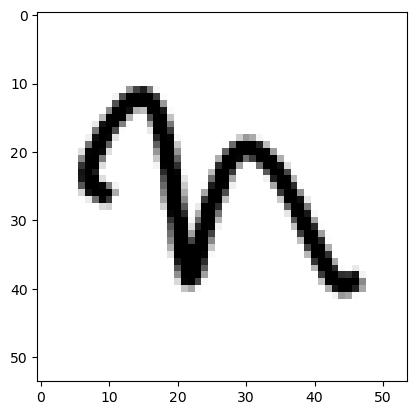

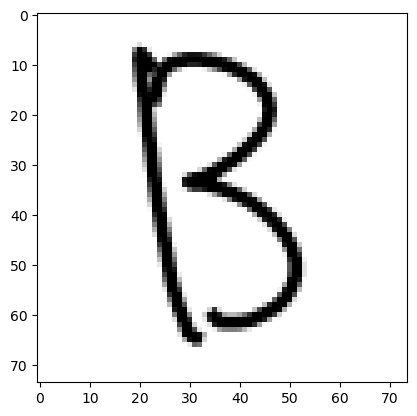

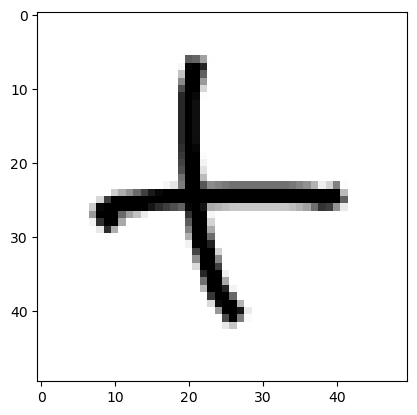

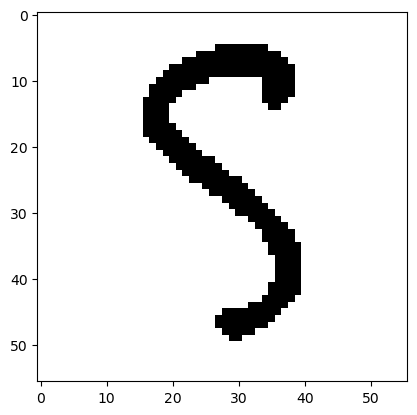

In [75]:
for i in range(5):
    plt.figure()
    plt.imshow(symbs[i], cmap='gray')

In [13]:
np.where(prediction == np.max(prediction))

(array([0]), array([0]))

In [14]:
y_prob = efficientnet_model.predict(resize_test) 


NameError: name 'resize_test' is not defined

In [ ]:
y_classes